In [1]:
# Setup kaggle, add kaggle.json to colab files.
! pip install -q kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! pwd

/content


In [2]:
# Make directory
! mkdir mango-leaf
%cd /content/mango-leaf

/content/mango-leaf


In [3]:
# Download dataset from kaggle
! kaggle datasets download aryashah2k/mango-leaf-disease-dataset

100% 103M/103M [00:02<00:00, 45.2MB/s] 
100% 103M/103M [00:02<00:00, 39.7MB/s]


In [4]:
# Unzip file
! unzip mango-leaf-disease-dataset.zip

Archive:  mango-leaf-disease-dataset.zip
  inflating: Anthracnose/20211008_124249 (Custom).jpg  
  inflating: Anthracnose/20211008_124250 (Custom).jpg  
  inflating: Anthracnose/20211008_124252 (Custom).jpg  
  inflating: Anthracnose/20211008_124253 (Custom).jpg  
  inflating: Anthracnose/20211008_124256 (Custom).jpg  
  inflating: Anthracnose/20211008_124301 (Custom).jpg  
  inflating: Anthracnose/20211008_124302 (Custom).jpg  
  inflating: Anthracnose/20211008_124305 (Custom).jpg  
  inflating: Anthracnose/20211008_124306 (Custom).jpg  
  inflating: Anthracnose/20211008_124310 (Custom).jpg  
  inflating: Anthracnose/20211008_124312 (Custom).jpg  
  inflating: Anthracnose/20211008_124334 (Custom).jpg  
  inflating: Anthracnose/20211008_124336 (Custom).jpg  
  inflating: Anthracnose/20211008_124341 (Custom).jpg  
  inflating: Anthracnose/20211008_124345 (Custom).jpg  
  inflating: Anthracnose/20211008_124457 (Custom).jpg  
  inflating: Anthracnose/20211008_124501 (Custom).jpg  
  infla

In [9]:
# Imports required for this project [1]
import os
import numpy as np
import pandas as pd
import cv2
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.preprocessing.image import img_to_array
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

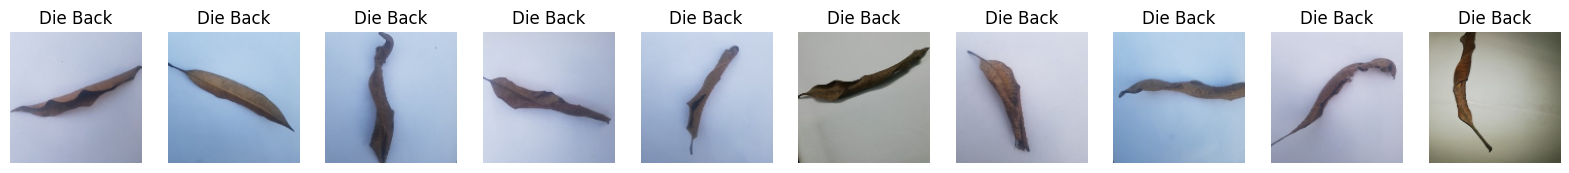

In [10]:
# Function to show off a class of the dataset [1]
def visualize_dataset(data_dir, img_height, img_width, num_samples=10):
    fig, axes = plt.subplots(1, num_samples, figsize=(20, 5))
    
    for folder in os.listdir(data_dir):
        folder_path = os.path.join(data_dir, folder)
        if os.path.isdir(folder_path):
            for i in range(num_samples):
                file = random.choice(os.listdir(folder_path))
                file_path = os.path.join(folder_path, file)
                if file.endswith('.jpg') or file.endswith('.png'):
                    img = cv2.imread(file_path)
                    img = cv2.resize(img, (img_height, img_width))
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                    axes[i].imshow(img)
                    axes[i].set_title(folder)
                    axes[i].axis('off')
            break

data_dir = '/content/mango-leaf'
img_height = 128
img_width = 128
visualize_dataset(data_dir, img_height, img_width)

In [11]:
# Function to load and preprocess the dataset [1]
def load_and_preprocess_data(data_dir, img_height, img_width):
    images = []
    labels = []

    for folder in os.listdir(data_dir):
        folder_path = os.path.join(data_dir, folder)
        if os.path.isdir(folder_path):
            for file in os.listdir(folder_path):
                file_path = os.path.join(folder_path, file)
                if file.endswith('.jpg') or file.endswith('.png'):
                    # Read image
                    img = cv2.imread(file_path)
                    # Resize image
                    img = cv2.resize(img, (img_height, img_width))
                    # Convert image to array
                    img_array = img_to_array(img)
                    # Normalize the image
                    img_array /= 255
                    # Append the image and label to the lists
                    images.append(img_array)
                    labels.append(folder)

    # Convert the lists to numpy arrays [1]
    images = np.array(images)
    labels = np.array(labels)

    # Convert the labels using one-hot encoding [1]
    label_encoder = LabelEncoder()
    integer_encoded = label_encoder.fit_transform(labels)
    onehot_encoder = OneHotEncoder(sparse=False)
    integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
    onehot_encoded = onehot_encoder.fit_transform(integer_encoded)

    return images, onehot_encoded, label_encoder

data_dir = '/content/mango-leaf'
img_height = 128
img_width = 128

X, y, label_encoder = load_and_preprocess_data(data_dir, img_height, img_width)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [12]:
# Load and preprocess the dataset
# (Implement a function to load and preprocess the images, and convert the labels to a suitable format)
train_ratio = 0.8
validation_ratio = 0.10
test_ratio = 0.10

# Split the data into train, validation, and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1 - train_ratio, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=test_ratio/(test_ratio + validation_ratio)) 

# Flatten the image data into a 2D array [1]
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_val_flat = X_val.reshape(X_val.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

# Standardize the data for non-deep learning algorithms [1]
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train_flat)
X_val_std = scaler.transform(X_val_flat)
X_test_std = scaler.transform(X_test_flat)


# Create a dictionary to store the results of each algorithm [1]
results = {}

In [28]:
# CNN [1]
# (Use the code from the previous response to implement the CNN, train the model, and evaluate the results)
# Determine the number of unique labels
num_classes = y.shape[1]

# Define the model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
    MaxPooling2D(2, 2),
    Dropout(0.3),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Dropout(0.3),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Dropout(0.3),

    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

# Compile the model [1]
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Define callbacks [1]
early_stopping = EarlyStopping(monitor='val_loss', patience=5)
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)

# Train the model [1]
history = model.fit(
    X_train, y_train,
    batch_size=32,
    epochs=10,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, model_checkpoint])

Epoch 1/10
100/100 [==============================] - 147s 1s/step - loss: 1.9455 - accuracy: 0.2044 - val_loss: 1.5582 - val_accuracy: 0.3950
Epoch 2/10
100/100 [==============================] - 145s 1s/step - loss: 1.3137 - accuracy: 0.4747 - val_loss: 0.8776 - val_accuracy: 0.7025
Epoch 3/10
100/100 [==============================] - 132s 1s/step - loss: 0.8806 - accuracy: 0.6719 - val_loss: 0.6329 - val_accuracy: 0.7775
Epoch 4/10
100/100 [==============================] - 133s 1s/step - loss: 0.6284 - accuracy: 0.7641 - val_loss: 0.6506 - val_accuracy: 0.7450
Epoch 5/10
100/100 [==============================] - 130s 1s/step - loss: 0.4904 - accuracy: 0.8194 - val_loss: 0.5564 - val_accuracy: 0.8100
Epoch 6/10
100/100 [==============================] - 132s 1s/step - loss: 0.3615 - accuracy: 0.8734 - val_loss: 0.2885 - val_accuracy: 0.8975
Epoch 7/10
100/100 [==============================] - 132s 1s/step - loss: 0.2530 - accuracy: 0.9087 - val_loss: 0.2615 - val_accuracy: 0.8925

In [30]:
#[1]
model.save('cnn.h5')

In [31]:
from tensorflow.keras.models import load_model
loaded_model = load_model('cnn.h5')

# Use the loaded model for testing
y_pred = loaded_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

# Print classification report and confusion matrix
print(classification_report(y_test_classes, y_pred_classes))
print(confusion_matrix(y_test_classes, y_pred_classes))
# Calculate the accuracy
cnn_accuracy = accuracy_score(y_test_classes, y_pred_classes)

# Add the CNN's accuracy to the results dictionary
results['CNN'] = cnn_accuracy

13/13 [==============================] - 5s 377ms/step
              precision    recall  f1-score   support

           0       0.96      0.96      0.96        55
           1       0.87      0.98      0.92        48
           2       1.00      1.00      1.00        46
           3       0.98      0.98      0.98        60
           4       0.92      0.88      0.90        51
           5       1.00      0.95      0.97        41
           6       0.92      0.94      0.93        52
           7       0.93      0.87      0.90        47

    accuracy                           0.95       400
   macro avg       0.95      0.95      0.95       400
weighted avg       0.95      0.95      0.95       400

[[53  0  0  1  1  0  0  0]
 [ 0 47  0  0  1  0  0  0]
 [ 0  0 46  0  0  0  0  0]
 [ 1  0  0 59  0  0  0  0]
 [ 1  5  0  0 45  0  0  0]
 [ 0  1  0  0  1 39  0  0]
 [ 0  0  0  0  0  0 49  3]
 [ 0  1  0  0  1  0  4 41]]


In [14]:
# Get the original class labels for class 4
class_4_label = label_encoder.inverse_transform([4])[0]

# Print the original class label for class 4
print(f"The original label for class 4 is: {class_4_label}")

The original label for class 4 is: Gall Midge


In [13]:
#[1]
print(loaded_model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 63, 63, 32)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 63, 63, 32)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 30, 30, 64)       

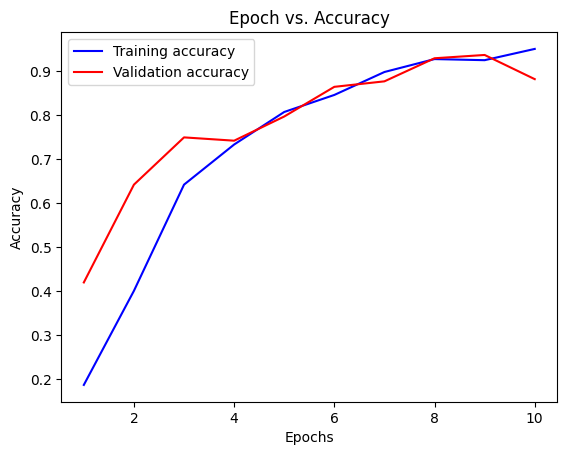

In [15]:
#[1]
import matplotlib.pyplot as plt

def plot_epoch_vs_accuracy(history):
    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    epochs = range(1, len(train_acc) + 1)

    plt.plot(epochs, train_acc, 'b', label='Training accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
    plt.title('Epoch vs. Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

plot_epoch_vs_accuracy(history)

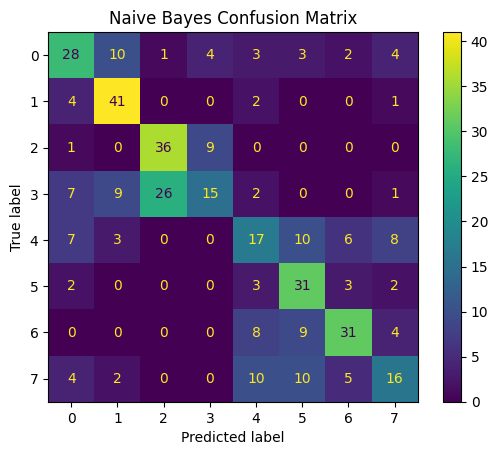

Naive Bayes Model Parameters:
{'priors': None, 'var_smoothing': 1e-09}


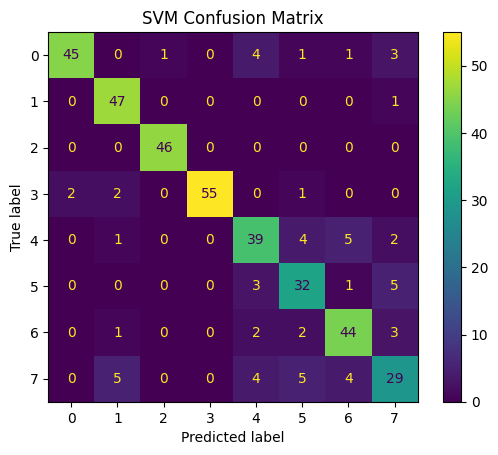

SVM Model Parameters:
{'C': 1, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf', 'max_iter': -1, 'probability': False, 'random_state': 42, 'shrinking': True, 'tol': 0.001, 'verbose': False}


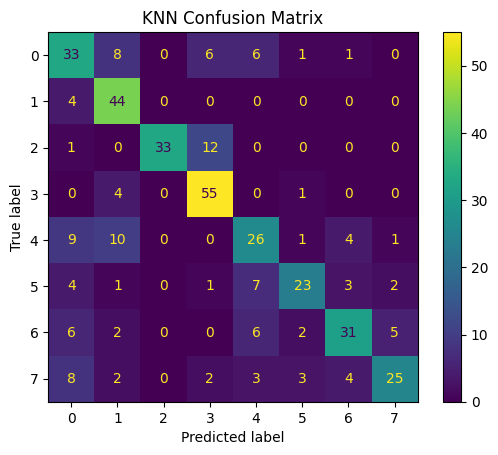

KNN Model Parameters:
{'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 3, 'p': 2, 'weights': 'uniform'}


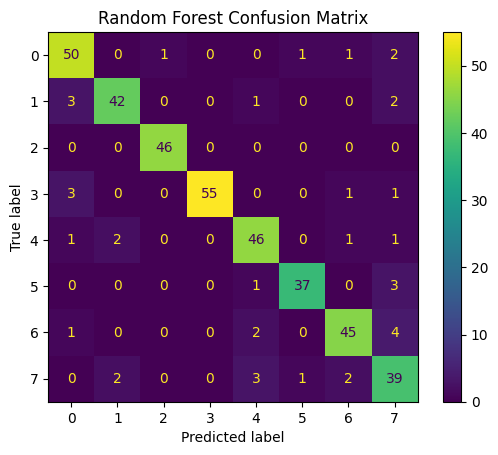

Random Forest Model Parameters:
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}


In [26]:
#[1]
import sklearn
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

# Convert one-hot encoded labels back to their original format
y_train_classes = np.argmax(y_train, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

# Create a list of class labels
class_labels = np.unique(y_test_classes)

# Naive Bayes
gnb = GaussianNB()
gnb.fit(X_train_std, y_train_classes)
gnb_pred = gnb.predict(X_test_std)
gnb_accuracy = accuracy_score(y_test_classes, gnb_pred)
results['Naive Bayes'] = gnb_accuracy


# Visualize Naive Bayes confusion matrix
confusion = confusion_matrix(y_test_classes, gnb_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=confusion, display_labels=class_labels)
disp.plot()
plt.title('Naive Bayes Confusion Matrix')
plt.show()


# Print Naive Bayes model parameters
print("Naive Bayes Model Parameters:")
print(gnb.get_params())

# SVM
svm = SVC(kernel='rbf', C=1, gamma='scale', random_state=42)
svm.fit(X_train_std, y_train_classes)
svm_pred = svm.predict(X_test_std)
svm_accuracy = accuracy_score(y_test_classes, svm_pred)
results['SVM'] = svm_accuracy

# Visualize SVM confusion matrix
confusion = confusion_matrix(y_test_classes, svm_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=confusion, display_labels=class_labels)
disp.plot()
plt.title('SVM Confusion Matrix')
plt.show()

# Print SVM model parameters
print("SVM Model Parameters:")
print(svm.get_params())

# KNN
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train_std, y_train_classes)
knn_pred = knn.predict(X_test_std)
knn_accuracy = accuracy_score(y_test_classes, knn_pred)
results['KNN'] = knn_accuracy

# Visualize KNN confusion matrix
confusion = confusion_matrix(y_test_classes, knn_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=confusion, display_labels=class_labels)
disp.plot()
plt.title('KNN Confusion Matrix')
plt.show()

# Print KNN model parameters
print("KNN Model Parameters:")
print(knn.get_params())

# Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_std, y_train_classes)
rf_pred = rf.predict(X_test_std)
rf_accuracy = accuracy_score(y_test_classes, rf_pred)
results['Random Forest'] = rf_accuracy

# Visualize Random Forest confusion matrix
confusion = confusion_matrix(y_test_classes, rf_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=confusion, display_labels=class_labels)
disp.plot()
plt.title('Random Forest Confusion Matrix')
plt.show()

# Print Random Forest model parameters
print("Random Forest Model Parameters:")
print(rf.get_params())


Accuracy Scores:
Naive Bayes: 0.5375
SVM: 0.8425
KNN: 0.675
Random Forest: 0.9
CNN: 0.9475


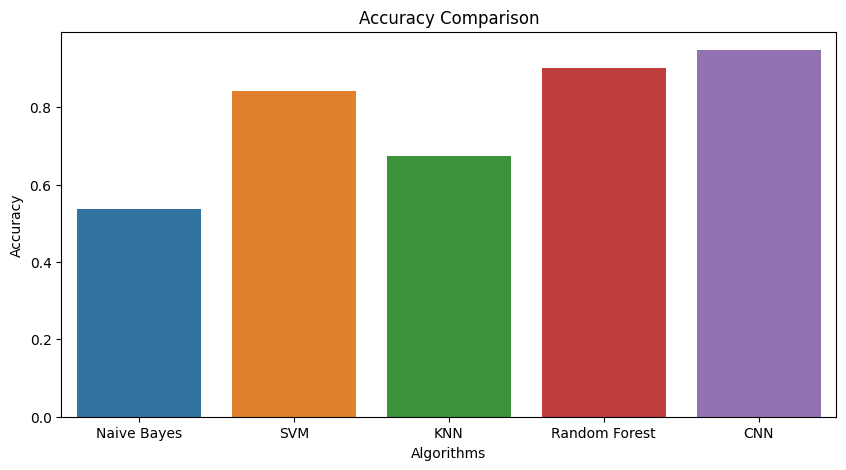

In [32]:
# Display the accuracy scores [1]
print("Accuracy Scores:")
for algorithm, accuracy in results.items():
    print(f"{algorithm}: {accuracy}")

# Visualize the results
plt.figure(figsize=(10, 5))
sns.barplot(x=list(results.keys()), y=list(results.values()))
plt.title("Accuracy Comparison")
plt.xlabel("Algorithms")
plt.ylabel("Accuracy")
plt.show()

#References
#[1] https://www.kaggle.com/code/abhisangharora/dm-proj